# Fake News Classifier

In [1]:
# importing basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
#importing data
real = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')
display(real.sample(5))
display(fake.sample(5))

title  \
7455   Kremlin: renewed dialogue needed between Washi...   
7790   Trump's son-in-law held talks to set up Trump ...   
20832  German anti-immigrant candidate walks out of T...   
2248   Climate change helped fuel record heat in 2016...   
2059   Rolling back Taliban grip on Afghan territory ...   

                                                    text       subject  \
7455   MOSCOW (Reuters) - Suggestions Russia interfer...  politicsNews   
7790   (Reuters) - Donald Trump’s son-in-law, Jared K...  politicsNews   
20832  BERLIN (Reuters) - One of the top candidates f...     worldnews   
2248   WASHINGTON (Reuters) - Global warming helped f...  politicsNews   
2059   WASHINGTON (Reuters) - Rolling back territoria...  politicsNews   

                     date  
7455    November 9, 2016   
7790    October 17, 2016   
20832  September 6, 2017   
2248     August 10, 2017   
2059     August 23, 2017

title  \
5474    This Liberal Group Found The BEST Way To Ruin...   
19543  BOYCOTT TRUMP APP LIST BACKFIRES…Shoppers Usin...   
22205        21WIRE.TV Members Newsletter – Feb 18, 2017   
2271    Trump Is Literally Causing Business Owners To...   
4285    WATCH: Chuck Todd HUMILIATES Rudy Giuliani Af...   

                                                    text    subject  \
5474   The Republican National Convention was already...       News   
19543  Here s the link to the app: BOYCOTT TRUMP This...  left-news   
22205  In this newsletter we ll include key updates o...    US_News   
2271   Rather than making America great again, Donald...       News   
4285   Appearing on NBC s Meet The Press Sunday morni...       News   

                    date  
5474       July 14, 2016  
19543       Nov 28, 2016  
22205  February 18, 2017  
2271       March 6, 2017  
4285     October 9, 2016

In [3]:
display(real.subject.value_counts())
display(fake.subject.value_counts()) # both have different subject category, but we will explore whether its required or not.

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [4]:
# Adding target column in both datasets before combining them.
real['target']=0
fake['target']=1

In [5]:
#combining bothe real and fake data for data cleaning and modeling
df = pd.concat([real,fake])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [6]:
# Shuffled the dataframe and reset the index
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.title[0]

'UNHCR says Australia abandoned refugees, must clear up the mess it made'

In [8]:
df.text[2]

'HARARE (Reuters) - Zimbabwe s stock market has shed $6 billion while its main index has slumped 40 percent since last Wednesday when the military seized power leading to the fall of Robert Mugabe, stock exchange data showed on Thursday. The main industrial index was at 315.12 points compared with 527.27 points on Wednesday last week when the military announced its takeover and put former president Mugabe under house arrest. On Thursday the index fell 4.4 percent. The Zimbabwe Stock Exchange had been on a rapid rise in the last two months, driven by investors seeking a safe haven for their investment amid fears of a return to hyperinflation in an economy suffering acute shortages of foreign exchange. But analysts said the market had entered a period of correction on investor optimism of a change in economic policy in a post-Mugabe era.  Market capitalization was $9 billion, down from $15 billion last week, bourse data showed. On the currency front, black market rates for buying cash do

In [9]:
# TextHero is a great package for data preprocessing
import texthero as hero

In [10]:
df['cleaned_text']=(df['text'].pipe(hero.remove_angle_brackets)
                    .pipe(hero.remove_brackets)
                    .pipe(hero.remove_curly_brackets)
                    .pipe(hero.remove_diacritics)
                    .pipe(hero.remove_digits)
                    .pipe(hero.remove_html_tags)
                    .pipe(hero.remove_punctuation)
                    .pipe(hero.remove_round_brackets)
                    .pipe(hero.remove_square_brackets)
                    .pipe(hero.remove_stopwords).pipe(hero.remove_urls).pipe(hero.remove_whitespace))

In [12]:
hero.top_words(df.cleaned_text)[:5]

said     132585
Trump    132266
The      115134
I         61678
would     54681
Name: cleaned_text, dtype: int64

In [60]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,f1_score,plot_confusion_matrix

In [15]:
tfid = TfidfVectorizer(max_features=1000)
X = tfid.fit_transform(df.cleaned_text).toarray()
y = df.target.values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [26]:
lr = LogisticRegression()
rf = RandomForestClassifier()
nb = MultinomialNB()

models = {'Logistic':lr,'Random Forest':rf,'Naive Bayes':nb}
for name,model in models.items():
    result = model.fit(X_train,y_train)
    y_pred = result.predict(X_test)
    print(name,'(Accuracy Score)',accuracy_score(y_test,y_pred))
    print(name,"(F1-Score)",f1_score(y_test,y_pred))

Logistic (Accuracy Score) 0.9775501113585746
Logistic (F1-Score) 0.9784135686140141
Random Forest (Accuracy Score) 0.9870824053452116
Random Forest (F1-Score) 0.9876269306254801
Naive Bayes (Accuracy Score) 0.9256124721603564
Naive Bayes (F1-Score) 0.9289059174116645


### The above result we get by considering only the text column. Now let's add title also.

In [29]:
df['title_text'] = df.title+' '+df.text
df['combined_text']=(df['title_text'].pipe(hero.remove_angle_brackets)
                    .pipe(hero.remove_brackets)
                    .pipe(hero.remove_curly_brackets)
                    .pipe(hero.remove_diacritics)
                    .pipe(hero.remove_digits)
                    .pipe(hero.remove_html_tags)
                    .pipe(hero.remove_punctuation)
                    .pipe(hero.remove_round_brackets)
                    .pipe(hero.remove_square_brackets)
                    .pipe(hero.remove_stopwords)
                     .pipe(hero.remove_urls)
                     .pipe(hero.remove_whitespace).pipe(hero.lowercase))
df.head()

title  \
0  UNHCR says Australia abandoned refugees, must ...   
1  Trump to ban transgender U.S. military personn...   
2  Zimbabwe bourse loses $6 billion, index falls ...   
3  COMEDY GOLD: Hillary Claims Trump “Unfit” To H...   
4  New Zealand National leader says will speak wi...   

                                                text       subject  \
0  GENEVA (Reuters) - The U.N refugee agency on F...     worldnews   
1  WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
2  HARARE (Reuters) - Zimbabwe s stock market has...     worldnews   
3  Watch as she s speaking to a crowd in Tampa, F...      politics   
4  WELLINGTON (Reuters) - New Zealand National Pa...     worldnews   

                  date  target  \
0   December 22, 2017        0   
1       July 26, 2017        0   
2   November 23, 2017        0   
3          Oct 7, 2016       1   
4  September 23, 2017        0   

                                        cleaned_text  \
0  GENEVA The U N refugee agency Friday accused A...   
1  WASHINGTON President Donald Trump said Wednesd...   
2  HARARE Zimbabwe stock market shed billion main...   
3  Watch speaking crowd Tampa Florida September m...   
4  WELLINGTON New Zealand National Party leader B...   

                                          title_text  \
0  UNHCR says Australia abandoned refugees, must ...   
1  Trump to ban transgender U.S. military personn...   
2  Zimbabwe bourse loses $6 billion, index falls ...   
3  COMEDY GOLD: Hillary Claims Trump “Unfit” To H...   
4  New Zealand National leader says will speak wi...   

                                       combined_text  
0  unhcr says australia abandoned refugees must c...  
1  trump ban transgender u s military personnel r...  
2  zimbabwe bourse loses billion index falls perc...  
3  comedy gold hillary claims trump unfit to hand...  
4  new zealand national leader says speak kingmak...

In [42]:
tfid = CountVectorizer(max_features=1000)
X = tfid.fit_transform(df.combined_text).toarray()
y = df.target.values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [44]:
lr = LogisticRegression()
rf = RandomForestClassifier()
nb = MultinomialNB()

models = {'Logistic':lr,'Random Forest':rf,'Naive Bayes':nb}
for name,model in models.items():
    result = model.fit(X_train,y_train)
    y_pred = result.predict(X_test)
    print(name,'(Accuracy Score)',accuracy_score(y_test,y_pred))
    print(name,"(F1-Score)",f1_score(y_test,y_pred))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic (Accuracy Score) 0.985478841870824
Logistic (F1-Score) 0.9861453463663409
Random Forest (Accuracy Score) 0.9903786191536749
Random Forest (F1-Score) 0.9908085106382979
Naive Bayes (Accuracy Score) 0.9486859688195991
Naive Bayes (F1-Score) 0.9511284574919396


### Now let's implement lemmatization

In [47]:
import nltk
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [48]:
def word_lemma(text):
    words = nltk.word_tokenize(text)
    lemma = [lemm.lemmatize(word) for word in words]
    joined_text = " ".join(lemma)
    return joined_text

In [50]:
df['lemmatized_data'] = df.combined_text.apply(lambda x:word_lemma(x))
df.head()

title  \
0  UNHCR says Australia abandoned refugees, must ...   
1  Trump to ban transgender U.S. military personn...   
2  Zimbabwe bourse loses $6 billion, index falls ...   
3  COMEDY GOLD: Hillary Claims Trump “Unfit” To H...   
4  New Zealand National leader says will speak wi...   

                                                text       subject  \
0  GENEVA (Reuters) - The U.N refugee agency on F...     worldnews   
1  WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
2  HARARE (Reuters) - Zimbabwe s stock market has...     worldnews   
3  Watch as she s speaking to a crowd in Tampa, F...      politics   
4  WELLINGTON (Reuters) - New Zealand National Pa...     worldnews   

                  date  target  \
0   December 22, 2017        0   
1       July 26, 2017        0   
2   November 23, 2017        0   
3          Oct 7, 2016       1   
4  September 23, 2017        0   

                                        cleaned_text  \
0  GENEVA The U N refugee agency Friday accused A...   
1  WASHINGTON President Donald Trump said Wednesd...   
2  HARARE Zimbabwe stock market shed billion main...   
3  Watch speaking crowd Tampa Florida September m...   
4  WELLINGTON New Zealand National Party leader B...   

                                          title_text  \
0  UNHCR says Australia abandoned refugees, must ...   
1  Trump to ban transgender U.S. military personn...   
2  Zimbabwe bourse loses $6 billion, index falls ...   
3  COMEDY GOLD: Hillary Claims Trump “Unfit” To H...   
4  New Zealand National leader says will speak wi...   

                                       combined_text  \
0  unhcr says australia abandoned refugees must c...   
1  trump ban transgender u s military personnel r...   
2  zimbabwe bourse loses billion index falls perc...   
3  comedy gold hillary claims trump unfit to hand...   
4  new zealand national leader says speak kingmak...   

                                     lemmatized_data  
0  unhcr say australia abandoned refugee must cle...  
1  trump ban transgender u s military personnel r...  
2  zimbabwe bourse loses billion index fall perce...  
3  comedy gold hillary claim trump unfit to handl...  
4  new zealand national leader say speak kingmake...

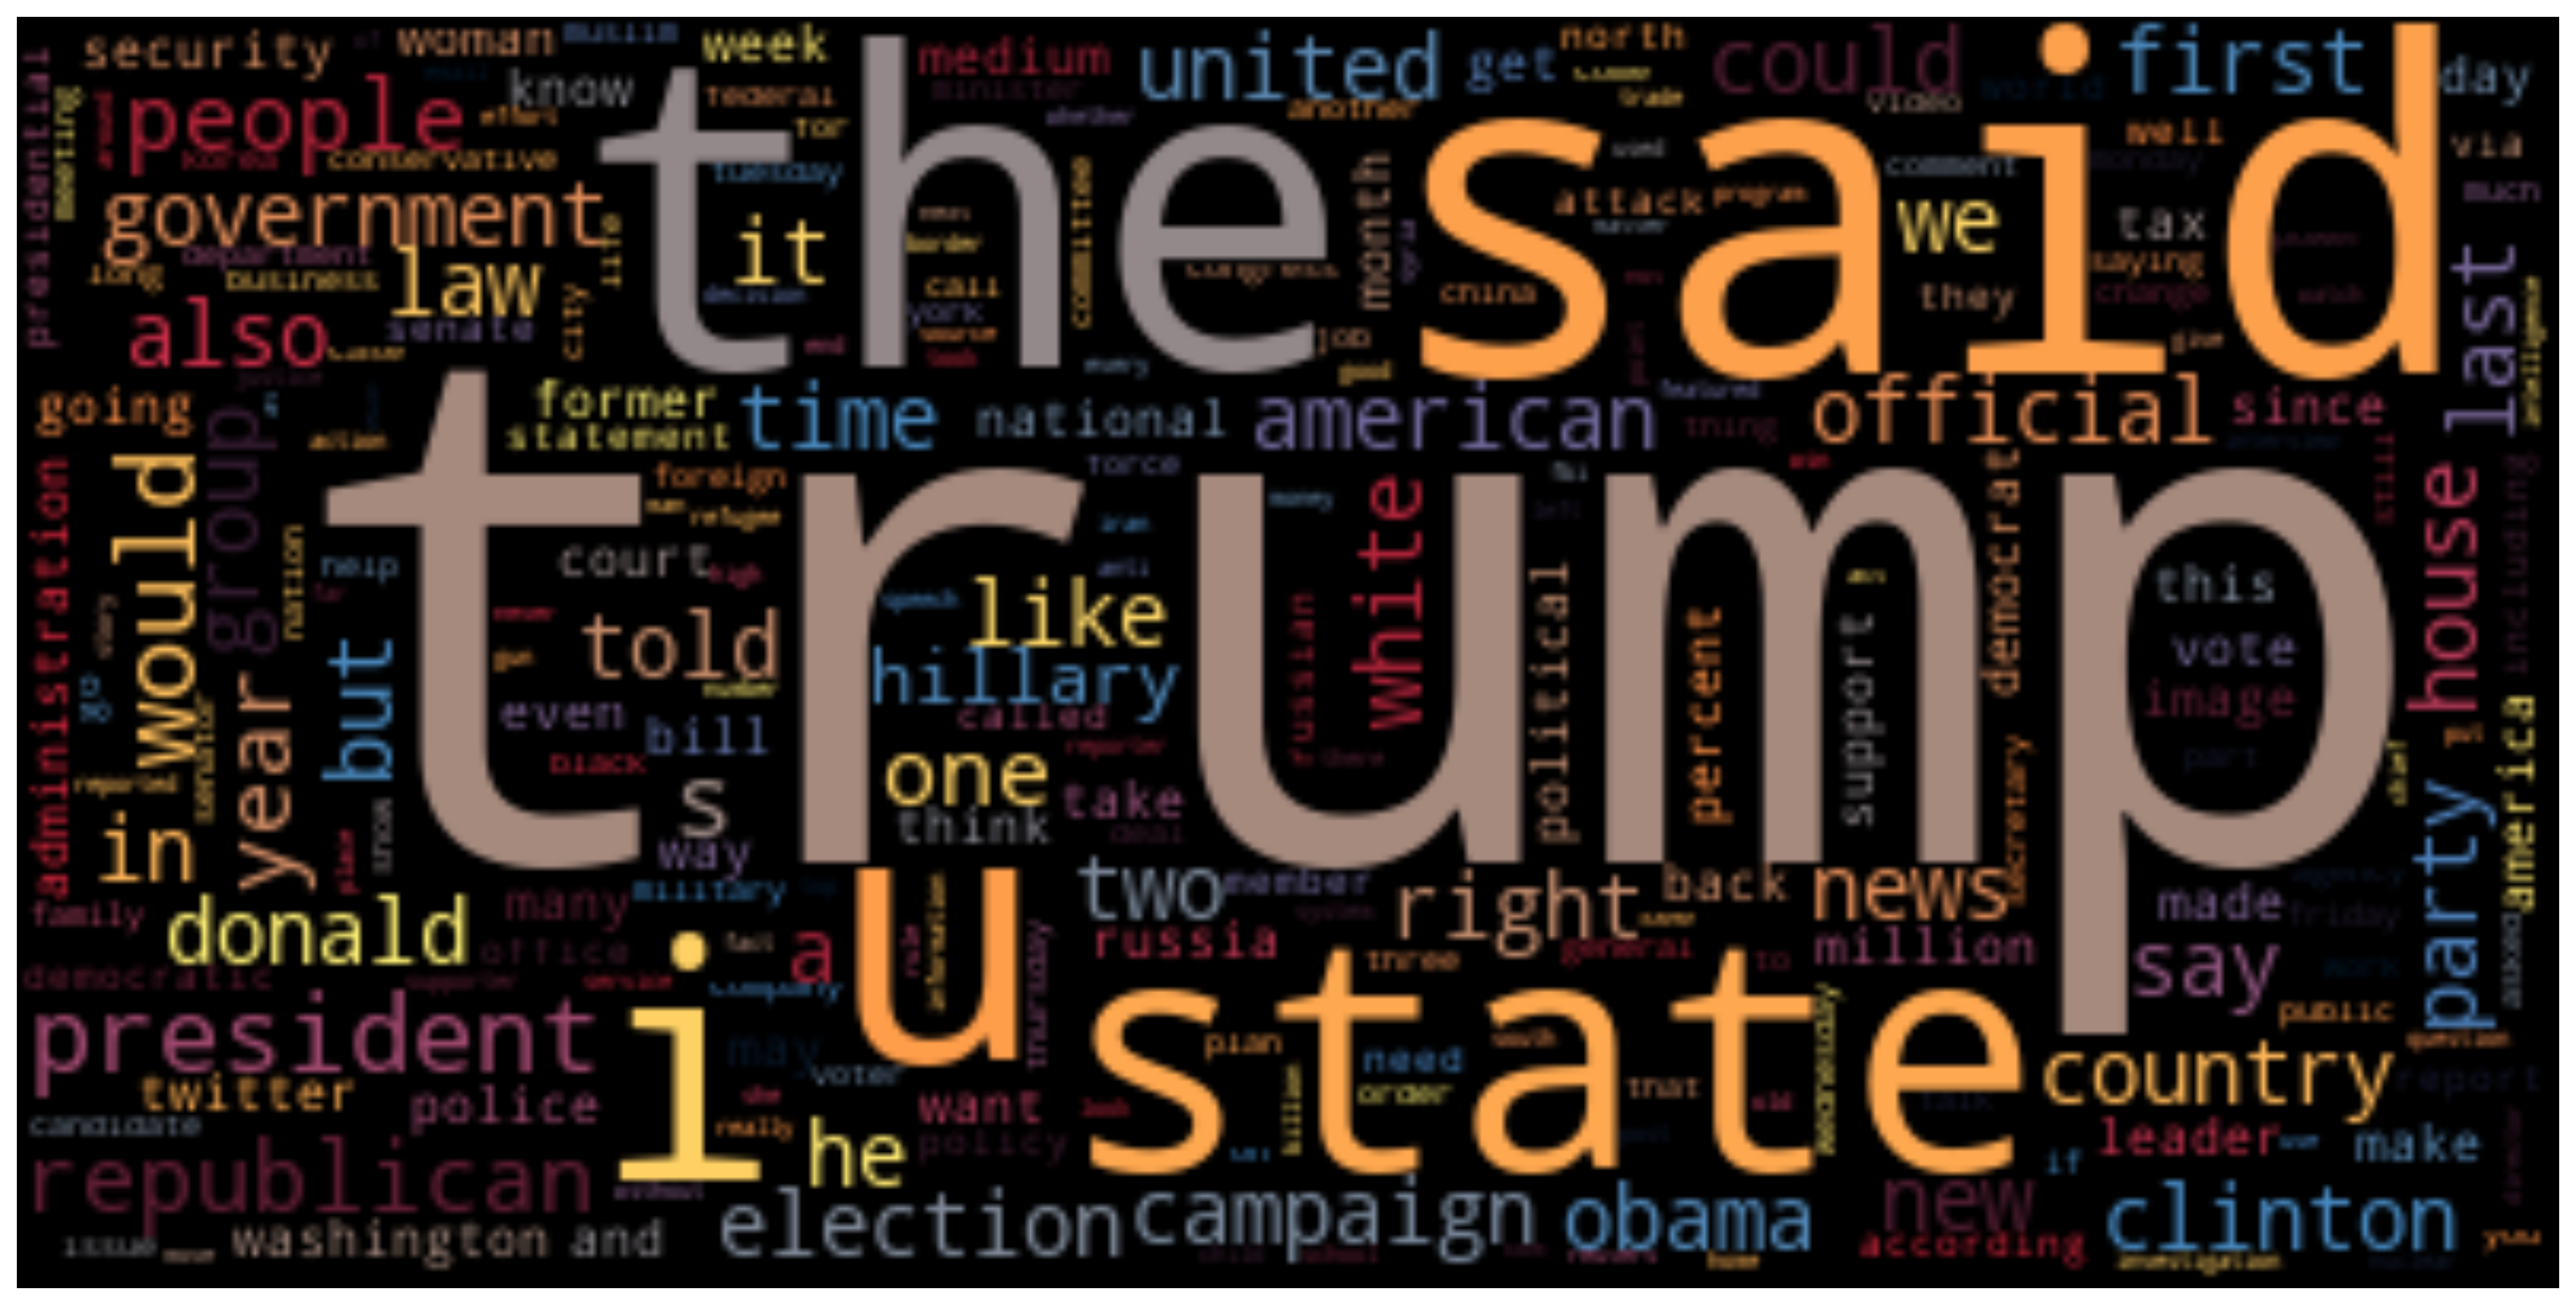

In [54]:
hero.visualization.wordcloud(df['lemmatized_data'], max_words=1000,background_color='BLACK')

In [51]:
tfid = CountVectorizer(max_features=1000)
X = tfid.fit_transform(df.lemmatized_data).toarray()
y = df.target.values

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [55]:
lr = LogisticRegression()
rf = RandomForestClassifier()
nb = MultinomialNB()

models = {'Logistic':lr,'Random Forest':rf,'Naive Bayes':nb}
for name,model in models.items():
    result = model.fit(X_train,y_train)
    y_pred = result.predict(X_test)
    print(name,'(Accuracy Score)',accuracy_score(y_test,y_pred))
    print(name,"(F1-Score)",f1_score(y_test,y_pred))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic (Accuracy Score) 0.9841425389755011
Logistic (F1-Score) 0.9848690921455286
Random Forest (Accuracy Score) 0.990913140311804
Random Forest (F1-Score) 0.9913280054412515
Naive Bayes (Accuracy Score) 0.944498886414254
Naive Bayes (F1-Score) 0.9471092622463707


### Now adding subject feature also 

In [56]:
df['title_text'] = df.title+' '+df.subject+' '+df.text
df['all_text']=(df['title_text'].pipe(hero.remove_angle_brackets)
                    .pipe(hero.remove_brackets)
                    .pipe(hero.remove_curly_brackets)
                    .pipe(hero.remove_diacritics)
                    .pipe(hero.remove_digits)
                    .pipe(hero.remove_html_tags)
                    .pipe(hero.remove_punctuation)
                    .pipe(hero.remove_round_brackets)
                    .pipe(hero.remove_square_brackets)
                    .pipe(hero.remove_stopwords)
                     .pipe(hero.remove_urls)
                     .pipe(hero.remove_whitespace).pipe(hero.lowercase))
df.head()

title  \
0  UNHCR says Australia abandoned refugees, must ...   
1  Trump to ban transgender U.S. military personn...   
2  Zimbabwe bourse loses $6 billion, index falls ...   
3  COMEDY GOLD: Hillary Claims Trump “Unfit” To H...   
4  New Zealand National leader says will speak wi...   

                                                text       subject  \
0  GENEVA (Reuters) - The U.N refugee agency on F...     worldnews   
1  WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
2  HARARE (Reuters) - Zimbabwe s stock market has...     worldnews   
3  Watch as she s speaking to a crowd in Tampa, F...      politics   
4  WELLINGTON (Reuters) - New Zealand National Pa...     worldnews   

                  date  target  \
0   December 22, 2017        0   
1       July 26, 2017        0   
2   November 23, 2017        0   
3          Oct 7, 2016       1   
4  September 23, 2017        0   

                                        cleaned_text  \
0  GENEVA The U N refugee agency Friday accused A...   
1  WASHINGTON President Donald Trump said Wednesd...   
2  HARARE Zimbabwe stock market shed billion main...   
3  Watch speaking crowd Tampa Florida September m...   
4  WELLINGTON New Zealand National Party leader B...   

                                          title_text  \
0  UNHCR says Australia abandoned refugees, must ...   
1  Trump to ban transgender U.S. military personn...   
2  Zimbabwe bourse loses $6 billion, index falls ...   
3  COMEDY GOLD: Hillary Claims Trump “Unfit” To H...   
4  New Zealand National leader says will speak wi...   

                                       combined_text  \
0  unhcr says australia abandoned refugees must c...   
1  trump ban transgender u s military personnel r...   
2  zimbabwe bourse loses billion index falls perc...   
3  comedy gold hillary claims trump unfit to hand...   
4  new zealand national leader says speak kingmak...   

                                     lemmatized_data  \
0  unhcr say australia abandoned refugee must cle...   
1  trump ban transgender u s military personnel r...   
2  zimbabwe bourse loses billion index fall perce...   
3  comedy gold hillary claim trump unfit to handl...   
4  new zealand national leader say speak kingmake...   

                                            all_text  
0  unhcr says australia abandoned refugees must c...  
1  trump ban transgender u s military personnel r...  
2  zimbabwe bourse loses billion index falls perc...  
3  comedy gold hillary claims trump unfit to hand...  
4  new zealand national leader says speak kingmak...

In [57]:
df['final_data'] = df.all_text.apply(lambda x:word_lemma(x))

In [58]:
tfid = CountVectorizer(max_features=1000)
X = tfid.fit_transform(df.final_data).toarray()
y = df.target.values

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

for name,model in models.items():
    result = model.fit(X_train,y_train)
    y_pred = result.predict(X_test)
    print(name,'(Accuracy Score)',accuracy_score(y_test,y_pred))
    print(name,"(F1-Score)",f1_score(y_test,y_pred))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic (Accuracy Score) 0.9987527839643653
Logistic (F1-Score) 0.9988081048867701
Random Forest (Accuracy Score) 0.9998218262806237
Random Forest (F1-Score) 0.9998296712655425
Naive Bayes (Accuracy Score) 0.9609799554565701
Naive Bayes (F1-Score) 0.9623711340206187


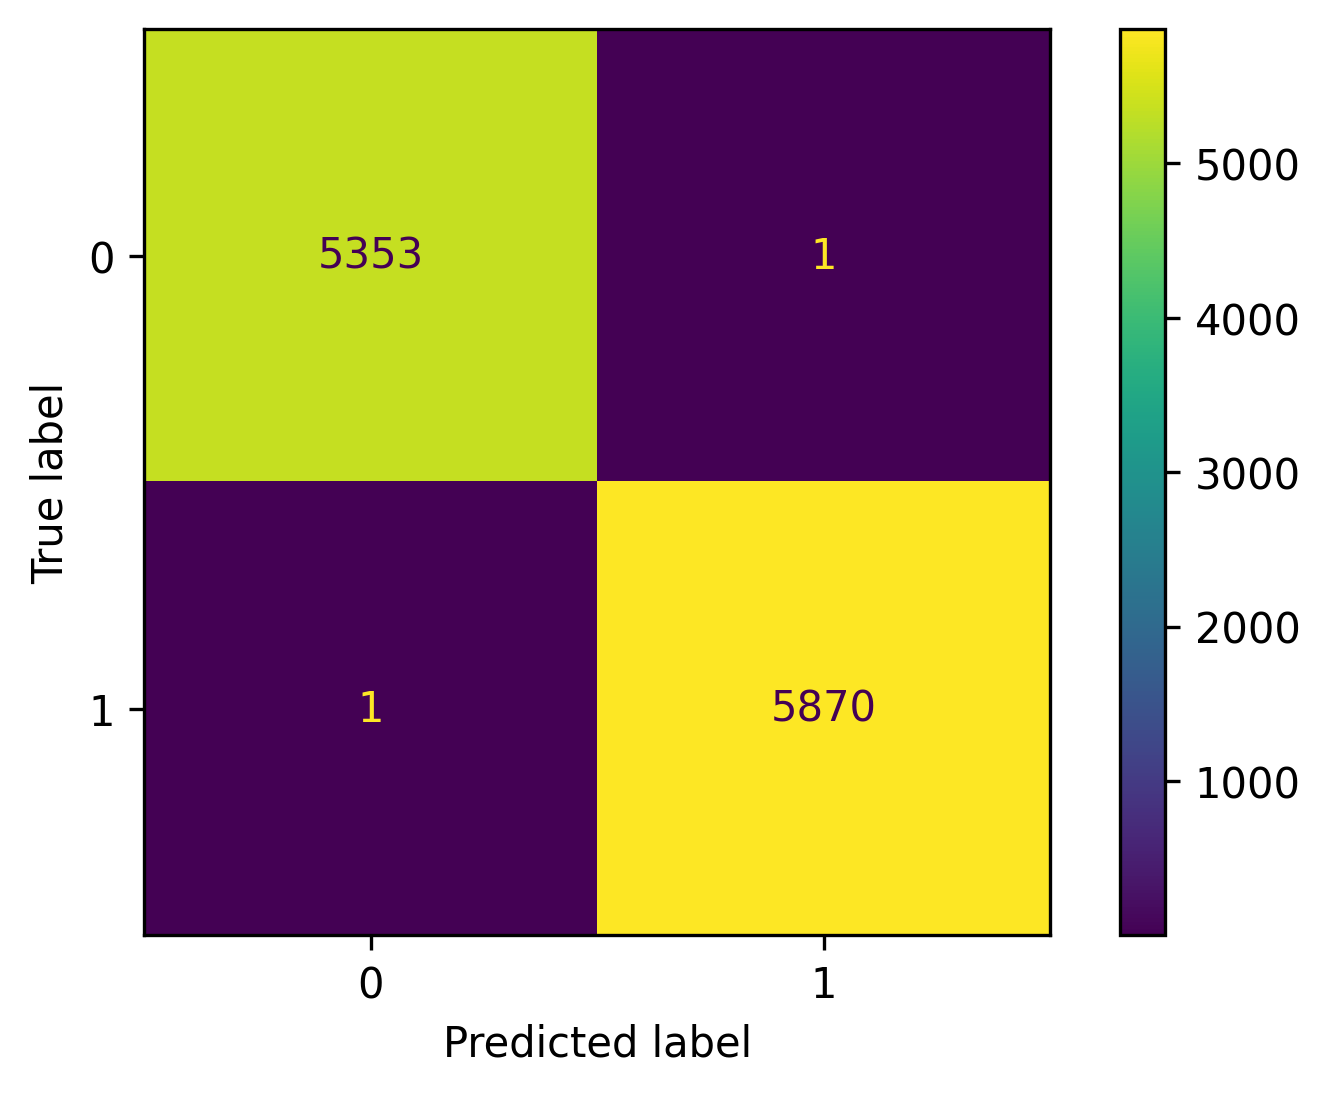

In [64]:
plot_confusion_matrix(rf,X_test,y_test)

### So Random Forest classifier is the best model among these 3 for predicting fake news.